In [1]:
pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 18.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.w

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define transformations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize the images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Freeze the parameters of the early layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes in CIFAR-10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only parameters of the classifier are being updated
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Determine if GPU is available and move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

100%|██████████| 170498071/170498071 [00:13<00:00, 13106176.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# Training and validation loop
num_epochs = 5
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:  # Get the inputs
        images, labels = images.to(device), labels.to(device)  # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:  # Change from train_loader to val_loader for validation
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print epoch results
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print('Finished Training')

Epoch [1/5]
Loss: 0.9684, Training Accuracy: 0.7013, Validation Accuracy: 0.7725
Epoch [2/5]
Loss: 0.6759, Training Accuracy: 0.7772, Validation Accuracy: 0.7867
Epoch [3/5]
Loss: 0.6274, Training Accuracy: 0.7883, Validation Accuracy: 0.7954
Epoch [4/5]
Loss: 0.6070, Training Accuracy: 0.7949, Validation Accuracy: 0.7985
Epoch [5/5]
Loss: 0.5928, Training Accuracy: 0.7972, Validation Accuracy: 0.8026
Finished Training


Files already downloaded and verified


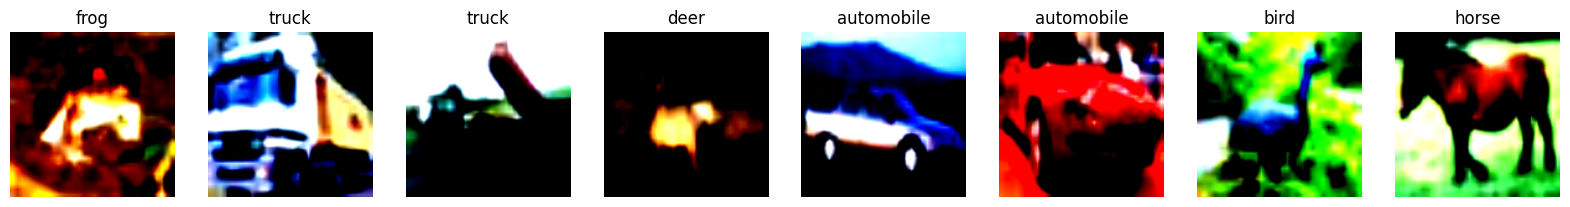

In [4]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize the images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define class names (update if needed to match your dataset)
classes = [
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
]

# Function to display images
def show_images(images, labels, class_names):
    fig, axes = plt.subplots(1, 8, figsize=(20, 3))
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for display
        axes[i].set_title(class_names[label])
        axes[i].axis('off')  # Hide axes
    plt.show()

# Extract 8 images and labels
images, labels = zip(*[dataset[i] for i in range(8)])

# Show the images with their class names
show_images(images, labels, classes)

In [5]:
# Save the trained model
model_path = 'resnet18_finetuned.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# Reinitialize the model
model = models.resnet18(pretrained=False)  # Initialize without pre-trained weights

# Modify the final layer to match the number of classes in CIFAR-10
model.fc = nn.Linear(num_ftrs, 10)

# Load the saved state dictionary
model_path = 'resnet18_finetuned.pth'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

print(f'Model loaded from {model_path}')

Model saved to resnet18_finetuned.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded from resnet18_finetuned.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted class index: 0
Predicted class label: airplane


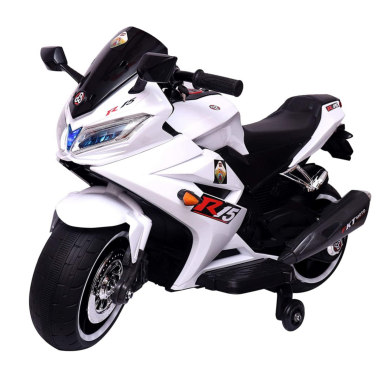

In [6]:
import requests
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from io import BytesIO
import matplotlib.pyplot as plt

# Reinitialize the model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(num_ftrs, 10)  # Adjust for CIFAR-10
model.load_state_dict(torch.load('resnet18_finetuned.pth'))
model.eval()

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def download_image(url):
    """
    Downloads an image from the given URL and returns it as a PIL Image.
    """
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return image

def show_image(image):
    """
    Displays the image using matplotlib.
    """
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Direct image URL
img_url = 'https://m.media-amazon.com/images/I/714Wty8IvxL.jpg'

# Download and preprocess the image
image = download_image(img_url)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
image_tensor = image_tensor.to(device)

with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class_index = predicted.item()

# Print prediction
print(f'Predicted class index: {predicted_class_index}')

# Optionally, you might want to map the class index to a human-readable label
# Assuming you have a list of class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_class_label = class_names[predicted_class_index]
print(f'Predicted class label: {predicted_class_label}')

# Show the image
show_image(image)

Predicted class index: 4
Predicted class label: deer


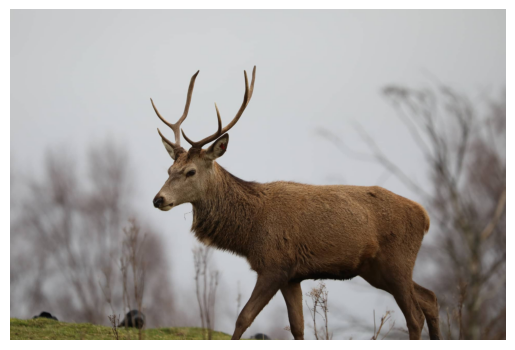

In [7]:
import requests
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from io import BytesIO
import matplotlib.pyplot as plt

# Reinitialize the model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(num_ftrs, 10)  # Adjust for CIFAR-10
model.load_state_dict(torch.load('resnet18_finetuned.pth'))
model.eval()

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def download_image(url):
    """
    Downloads an image from the given URL and returns it as a PIL Image.
    """
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return image

def show_image(image):
    """
    Displays the image using matplotlib.
    """
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Direct image URL
img_url = 'https://images.rzss.org.uk/media/Highland_Wildlife_Park/HWP_animals/Red_deer/red_deer_3.jpg'

# Download and preprocess the image
image = download_image(img_url)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
image_tensor = image_tensor.to(device)

with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class_index = predicted.item()

# Print prediction
print(f'Predicted class index: {predicted_class_index}')

# Optionally, you might want to map the class index to a human-readable label
# Assuming you have a list of class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_class_label = class_names[predicted_class_index]
print(f'Predicted class label: {predicted_class_label}')

# Show the image
show_image(image)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The image has likely been attacked by an adversarial perturbation.


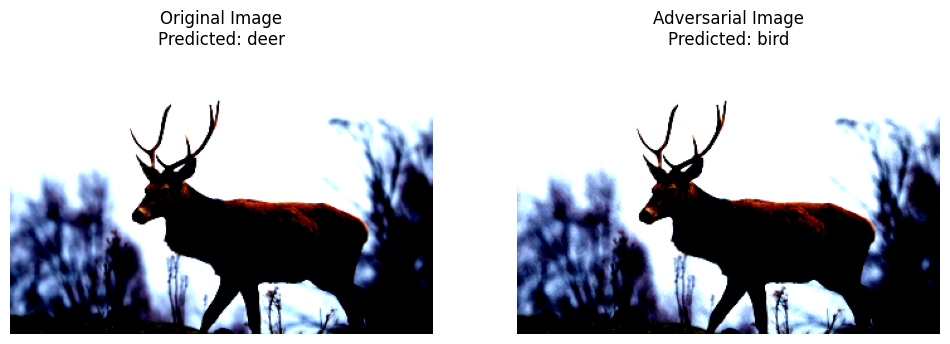

Original Prediction: deer
Adversarial Prediction: bird
Success Rate: 1.0


In [8]:
import requests
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchattacks

# Reinitialize the model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(num_ftrs, 10)  # Adjust for CIFAR-10
model.load_state_dict(torch.load('resnet18_finetuned.pth'))
model.eval()

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def download_image(url):
    """
    Downloads an image from the given URL and returns it as a PIL Image.
    """
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return image

def show_image(image, title):
    """
    Displays the image using matplotlib.
    """
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Hide axes
    plt.show()

# Direct image URL
img_url = 'https://images.rzss.org.uk/media/Highland_Wildlife_Park/HWP_animals/Red_deer/red_deer_3.jpg'

# Download and preprocess the image
original_image = download_image(img_url)
original_image_tensor = transform(original_image).unsqueeze(0)  # Add batch dimension

# Perform inference on the original image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
original_image_tensor = original_image_tensor.to(device)

with torch.no_grad():
    original_outputs = model(original_image_tensor)
    original_prediction = torch.argmax(original_outputs, 1).item()
    original_class_label = class_names[original_prediction]

# Define the SINIFGSM attack
attack_SINIFGSM = torchattacks.SINIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0, m=5)

# Apply the SINIFGSM attack to the original image
original_label_tensor = torch.tensor([original_prediction]).to(device)
adv_image_tensor = attack_SINIFGSM(original_image_tensor, original_label_tensor)

# Predictions on adversarial image
with torch.no_grad():
    adversarial_outputs = model(adv_image_tensor)
    adversarial_prediction = torch.argmax(adversarial_outputs, 1).item()
    adversarial_class_label = class_names[adversarial_prediction]

# Check if the predictions differ
attack_success = original_prediction != adversarial_prediction
if attack_success:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Show the original and adversarial images along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axs[0].imshow(np.transpose(original_image_tensor.squeeze().cpu().numpy(), (1, 2, 0)))
axs[0].set_title(f"Original Image\nPredicted: {original_class_label}")
axs[0].axis('off')

# Adversarial image
adv_image = adv_image_tensor.squeeze().cpu().detach().numpy()
axs[1].imshow(np.transpose(adv_image, (1, 2, 0)))
axs[1].set_title(f"Adversarial Image\nPredicted: {adversarial_class_label}")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", original_class_label)
print("Adversarial Prediction:", adversarial_class_label)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 1  # Since we are testing one sample

if attack_success:
    successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

In [9]:
# Load pre-trained model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # Adjust for CIFAR-10
model.load_state_dict(torch.load('resnet18_finetuned.pth'))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define attacks
attacks = {
    'VANILA': torchattacks.VANILA(model),
    'GN': torchattacks.GN(model),
    'FGSM': torchattacks.FGSM(model, eps=8/255),
    'BIM': torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10),
    'RFGSM': torchattacks.RFGSM(model, eps=8/255, alpha=2/255, steps=10)
}

# Initialize variables to count successful attacks
successful_attacks = {attack_name: 0 for attack_name in attacks.keys()}
total_samples = 0

# Iterate over the test dataset
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total_samples += labels.size(0)

    # Apply the attacks
    adversarial_images = {name: attack(images, labels) for name, attack in attacks.items()}

    # Predictions on original and adversarial images
    with torch.no_grad():
        original_predictions = torch.argmax(model(images), dim=1)
        adversarial_predictions = {name: torch.argmax(model(adv_images), dim=1) for name, adv_images in adversarial_images.items()}

    # Check if the predictions differ for each attack
    for name, adv_predictions in adversarial_predictions.items():
        successful_attacks[name] += (original_predictions != adv_predictions).sum().item()

# Calculate the success rate for each attack
success_rates = {name: count / total_samples for name, count in successful_attacks.items()}

# Print the success rates for each attack
for name, rate in success_rates.items():
    print(f"{name} Success Rate: {rate:.4f}")

# Compare which attack has the highest success rate
highest_success_rate = max(success_rates.values())
best_attack = [name for name, rate in success_rates.items() if rate == highest_success_rate]

print(f"{', '.join(best_attack)} has the highest success rate.")


VANILA Success Rate: 0.0000
GN Success Rate: 0.8270
FGSM Success Rate: 0.8190
BIM Success Rate: 0.8818
RFGSM Success Rate: 0.9612
RFGSM has the highest success rate.
